In [1]:
!pip install seaborn
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import torch
import torch.distributions as dist
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from datetime import datetime
from numpy.polynomial.chebyshev import Chebyshev
#%matplotlib notebook
random_seed = 1
np.random.seed(seed=random_seed)
torch.manual_seed(random_seed)
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
path = os.path.join(os.getcwd(), "plot/")
today=datetime.today().strftime('%Y-%m-%d')

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
class FHatNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(FHatNetwork, self).__init__()
        layers = []
        if hidden_sizes == []:
            self.model = nn.Linear(input_size, output_size)
        else:
            layers.append(nn.Linear(input_size, hidden_sizes[0]))
            layers.append(nn.ReLU())
            for i in range(1, len(hidden_sizes)):
                layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
                layers.append(nn.ReLU())
            layers.append(nn.Linear(hidden_sizes[-1], output_size))
            self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

# Define the hypernetwork
class HyperNetwork(nn.Module):
    def __init__(self, input_dim):
        super(HyperNetwork, self).__init__()
        self.input_dim = input_dim
        self.hyper_layer = FHatNetwork(1,[10],input_dim)
        
    def forward(self, x, alpha):
        alpha = alpha.unsqueeze(0)
        params = torch.tanh(self.hyper_layer(alpha))
        params = params.view(self.input_dim, 1)
        return x@params

**Preliminaries** In the following, the classes are defined to initiate the aggregation functions $\rho_{\alpha}$ and the aggregated risk minimization (ARM) optimization for a simple 1D and 2D regression task.

In [6]:
class aggregation_function:    
    """ This class aggregates the risks. """
    def __init__(self, name:str):
        self.name = name
    def aggregate(self, risks, alpha) -> float:
        if self.name == 'cvar':
            return self.cvar(risks, alpha)
        else:
            raise NotImplementedError("Currently, only CVaR is implemented.")
    def cvar(self, risks, alpha) -> float:
        var = torch.quantile(risks,alpha, interpolation='linear')
        cvar = risks[risks > var].mean()
        return cvar

In [7]:
class ARM_Regression:
    def __init__(self, name, experiment="1D_linear"):      
        self.aggregator = aggregation_function(name=name)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    def compute_cvar_h(self, alpha, h, env_dict):
        with torch.no_grad():
            risks = []
            for e in env_dict.keys():
                output = h(env_dict[e]['x'].to(self.device), alpha.to(self.device))
                risks.append(loss_fn(env_dict[e]['y'].to(self.device),output))
            risks = torch.stack(risks)
            cvar = self.aggregator.aggregate(risks, alpha)
        return cvar
    
    def fit_h(self, h, env_dict, alphas):        
        learning_rate = 0.01
        num_epochs= 200
        d = env_dict[0]['x'].shape[1]
        loss_fn = torch.nn.MSELoss()        
        optimizer = torch.optim.Adam(h.parameters(), lr=learning_rate)
        scheduler = StepLR(optimizer, step_size=100, gamma=0.1)
        for epoch in range(num_epochs):
            for alpha in alphas:
                risks = []
                for e in env_dict.keys():
                    risks.append(loss_fn(env_dict[e]['y'].to(self.device),h(env_dict[e]['x'].to(self.device),alpha.to(self.device)))) 
                risks = torch.stack(risks)
                cvar = self.aggregator.aggregate(risks, alpha)
                cvar.backward()
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
            if (epoch + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {cvar.item()}")
        return 
    
    def iterative_implementation(self, h, cheb_approx, env_dict, loss_fn):
        tests = np.random.uniform(low=0, high=1, size=100)
        tests = torch.tensor(tests, dtype=torch.float32).to(device)
        for test in tests:
            cvar_cheb = cheb_approx(test)
            cvar_h = self.compute_cvar_h(test, h, env_dict)
            if cvar_cheb < cvar_h:
                return test
        return "exit"
    
    def fit_h_chebyshev(self, h, env_dict, start, budget):
        learning_rate = 0.01
        d = env_dict[0]['x'].shape[1]
        loss_fn = torch.nn.MSELoss()        
        optimizer = torch.optim.Adam(h.parameters(), lr=learning_rate)
        scheduler = StepLR(optimizer, step_size=100, gamma=0.1)
        alphas = np.cos((np.pi * (2 * np.arange(1, budget + 1) - 1)) / (2 * budget)) / 2 + 0.5
        alphas = torch.tensor(alphas, dtype=torch.float32).to(self.device) 
        while (budget):
            self.fit_h(h, env_dict, alphas)
            cvar_values = np.array([self.compute_cvar_h(alpha, h, env_dict) for alpha in alphas])
            cheb_approx = Chebyshev.fit(alphas, cvar_values, deg=budget-1)
            alpha = self.iterative_implementation(h, cheb_approx, env_dict, loss_fn)
            if alpha == "exit":
                return 
            else:
                alphas = torch.cat((alphas,alpha.unsqueeze(0)), dim=0)
            budget=budget-1
        return 
    
    def monte_carlo_h(self, h, env_dict, loss_fn, num_samples=10):
        cvar_estimates = []
        alphas = np.random.uniform(low=0, high=1, size=num_samples)
        alphas = torch.tensor(alphas, dtype=torch.float32).to(self.device)
        for alpha in alphas:
            risks = []
            for e in env_dict.keys():
                risks.append(loss_fn(env_dict[e]['y'].to(device),h(env_dict[e]['x'].to(device), alpha)))
            risks = torch.stack(risks)
            cvar_sample = self.aggregator.aggregate(risks, alpha)
            cvar_estimates.append(cvar_sample)
        cvar_estimates = torch.stack(cvar_estimates)
        average_cvar = torch.mean(cvar_estimates)
        return average_cvar     
    
    def fit_h_new(self, h, env_dict):
        learning_rate = 0.01
        num_epochs= 100
        d = env_dict[0]['x'].shape[1]
        loss_fn = torch.nn.MSELoss()        
        optimizer = torch.optim.Adam(h.parameters(), lr=learning_rate)
        scheduler = StepLR(optimizer, step_size=100, gamma=0.1)
        for epoch in range(num_epochs):
            avg_cvar = self.monte_carlo_h(h, env_dict, loss_fn, num_samples=100)
            avg_cvar.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            if (epoch + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_cvar.item()}")
        return   
    
    def fit_f(self, f, env_dict, alpha):        
        learning_rate = 0.01
        num_epochs= 200
        d = env_dict[0]['x'].shape[1]
        loss_fn = torch.nn.MSELoss()        
        optimizer = torch.optim.Adam(f.parameters(), lr=learning_rate)
        scheduler = StepLR(optimizer, step_size=100, gamma=0.1)
        for epoch in range(num_epochs):
            risks = torch.stack([loss_fn(env_dict[e]['y'].to(self.device),f(env_dict[e]['x'].to(self.device))) for e in env_dict.keys()])
            cvar = self.aggregator.aggregate(risks, alpha)
            cvar.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            if (epoch + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {cvar.item()}")
        return 


**Experiment 1** We assume the following *linear* data generation process $$Y(X) = X*\theta_{e}+\epsilon$$ and *nonlinear* data generation process $$Y(X) = sin(X*\theta_{e})+\epsilon$$.

**Experiment 1A** Assume a linear model $Y_{e}=\theta_{e}X+\epsilon$, where $X \sim \mathcal{N}(2,0.2)$ and $\epsilon\sim \mathcal{N}(0,0.1)$. We simulate different environments by drawing $\theta$ from a beta distribution $Beta(0.1,0.2)$. In total, we generate for 25 environments 100 observations each.

**Experiment 1B** Assume the same setting as in Experiment 1, however, in contrast, we simulate different environments by drawing $\theta$ from a uniform distribution $\ \mathcal{U}(0,1)$. In total, we generate for 25 environments 100 observations each.

In [8]:
class data_generator:
    
    """ This class generates the simulation data. """
    

    def __init__(self, envs_train = 25, envs_test = 25, 
                 size_train = 1000, size_test= 100, 
                 theta_dist="uniform",
                 dim=1):
        
        self.envs_train = envs_train
        self.envs_test = envs_test
        self.size_train = size_train
        self.size_test = size_test
        self.theta_dist = theta_dist
        self.dim = dim 
        
    def generate(self) -> dict:           
        env_list_train = [f'e_{i}' for i in range(1,self.envs_train+1,1)]
        env_dict_train = dict(list(enumerate(env_list_train)))
        env_list_test  = [f'e_{i}' for i in range(1,self.envs_test+1,1)]
        env_dict_test  = dict(list(enumerate(env_list_test)))
        
        
        for e_train in env_dict_train.keys():
            if self.theta_dist == "uniform": 
                distribution = dist.Uniform(0, 1)
            else:
                distribution = dist.Beta(0.1, 0.2)
            theta_true = distribution.sample((self.dim,1))
            x_train = dist.normal.Normal(loc=1.0/self.dim, scale=0.5).sample((self.size_train,self.dim))
            noise_train = dist.normal.Normal(loc=0, scale=0.05).sample((self.size_train,self.dim))
            y_train = (1.0/math.sqrt(self.dim))*x_train@theta_true + noise_train
            env_dict_train[e_train] = {'x': x_train,'y': y_train,'theta_true': theta_true}
            
        for e_test in env_dict_test.keys():
            if self.theta_dist == "uniform": 
                distribution = dist.Uniform(0, 1)
            else:
                distribution = dist.Beta(0.1, 0.2)
            theta_true = distribution.sample((self.dim,1))
            x_test = dist.normal.Normal(loc=1.0/self.dim, scale=0.5).sample((self.size_test,self.dim))
            noise_test = dist.normal.Normal(loc=0, scale=0.05).sample((self.size_test,self.dim))
            y_test = (1.0/math.sqrt(self.dim))*x_test@theta_true + noise_test
            env_dict_test[e_test] = {'x': x_test,'y': y_test,'theta_true': theta_true}
            
        return env_dict_train, env_dict_test

In [9]:
# Instantiate the target network and hypernetwork
dim = 1
h = HyperNetwork(dim).to(device)

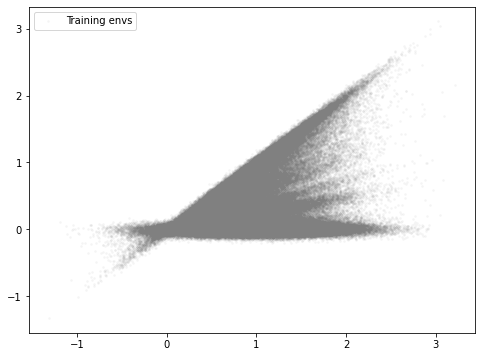

In [10]:
# Intitialize the experiment and generate the data
envs_train, envs_test = 250, 250
size_train, size_test = 1000 , 1000
theta_dist="beta" 
rho="cvar"

generator = data_generator(envs_train, envs_test, size_train, size_test, theta_dist, dim)
data_dict_train, data_dict_test = generator.generate()
# Define some example dimensions
generator = data_generator(envs_train, envs_test, size_train, size_test, theta_dist, dim)
data_dict_train, data_dict_test = generator.generate()
fig, ax = plt.subplots(1,1, figsize=(8,6))

X_train = [data_dict_train[e]['x'].ravel() for e in data_dict_train.keys()]
X_train = np.array([item for sublist in X_train for item in sublist]).reshape(-1,1)
Y_train = [data_dict_train[e]['y'] for e in data_dict_train.keys()]
Y_train = np.array([item for sublist in Y_train for item in sublist]).reshape(-1,1)

ax.scatter(y=Y_train, x=X_train, s=3, c="grey", alpha=0.05, label="Training envs")
ax.legend(loc='upper left')

Epoch [100/200], Loss: 0.2294645756483078
Epoch [200/200], Loss: 0.2294425070285797
Epoch [100/200], Loss: 0.27716153860092163
Epoch [200/200], Loss: 0.27716147899627686


  0%|          | 0/20 [00:00<?, ?it/s]

alpha:  tensor(0.)  CVaR:  0.20113340020179749
alpha:  tensor(0.0500)  CVaR:  0.20967945456504822
alpha:  tensor(0.1000)  CVaR:  0.21915476024150848
alpha:  tensor(0.1500)  CVaR:  0.22993281483650208
alpha:  tensor(0.2000)  CVaR:  0.23951078951358795
alpha:  tensor(0.2500)  CVaR:  0.24897415935993195
alpha:  tensor(0.3000)  CVaR:  0.2573595345020294
alpha:  tensor(0.3500)  CVaR:  0.26626086235046387
alpha:  tensor(0.4000)  CVaR:  0.27445510029792786
alpha:  tensor(0.4500)  CVaR:  0.2832614481449127
alpha:  tensor(0.5000)  CVaR:  0.29146116971969604
alpha:  tensor(0.5500)  CVaR:  0.2992309331893921
alpha:  tensor(0.6000)  CVaR:  0.30698689818382263
alpha:  tensor(0.6500)  CVaR:  0.3135271668434143
alpha:  tensor(0.7000)  CVaR:  0.3201960623264313
alpha:  tensor(0.7500)  CVaR:  0.3244361877441406
alpha:  tensor(0.8000)  CVaR:  0.3256237506866455
alpha:  tensor(0.8500)  CVaR:  0.322358638048172
alpha:  tensor(0.9000)  CVaR:  0.33489158749580383
alpha:  tensor(0.9500)  CVaR:  0.35329169034

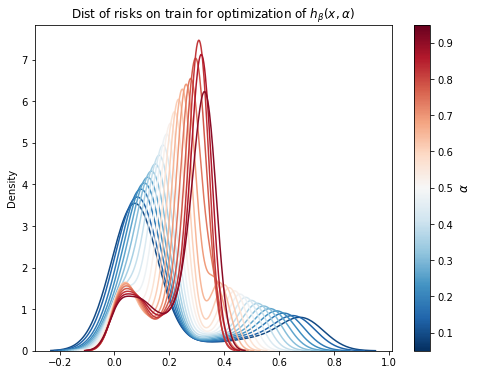

In [11]:
#Run the ARM regression task
loss_fn = torch.nn.MSELoss()
results = pd.DataFrame(columns = ["alpha", "cvar"])
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8,6))
rg = torch.arange(0,1,0.05)
diverging_colors = sns.color_palette("RdBu", len(rg))
ARM_Regression(name=rho).fit_h_chebyshev(h, data_dict_train, 10, 2) 
h.eval()
j=1
for alpha in tqdm(rg):
    with torch.no_grad():
        risks = torch.stack([loss_fn(data_dict_train[e]['y'].to(device), h(data_dict_train[e]['x'].to(device), alpha.to(device))) for e in data_dict_train.keys()])
        cvar_emp = aggregation_function(name="cvar").aggregate(risks.cpu(), alpha.cpu())     
        sns.kdeplot(risks.cpu().numpy(), ax=ax,color=diverging_colors[len(rg)-j], label=str(alpha.item()))
        print("alpha: ", alpha, " CVaR: ",cvar_emp.item())
    results.at[int(alpha.item()*100), "alpha"] = alpha
    results.at[int(alpha.item()*100), "cvar"] = cvar_emp
    j+=1
ax.legend(bbox_to_anchor=(1.02, 1.02), title=r"$\alpha$", loc='upper left')
ax.set_title(r"Dist of risks on train for optimization of $h_\beta(x,\alpha)$")
norm = plt.Normalize(0.05, 0.95)
sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
sm.set_array([])
ax.get_legend().remove()
ax.figure.colorbar(sm).set_label(label= r'$\alpha$',labelpad=5,size=12)

In [12]:
#torch.save(h, 'hypernetwork_25_1k.pth')
#h = torch.load('hypernetwork_25_1k.pth')

  0%|          | 0/20 [00:00<?, ?it/s]

alpha:  tensor(0.)  CVaR:  0.20113340020179749
alpha:  tensor(0.0500)  CVaR:  0.20967945456504822
alpha:  tensor(0.1000)  CVaR:  0.21915476024150848
alpha:  tensor(0.1500)  CVaR:  0.22993281483650208
alpha:  tensor(0.2000)  CVaR:  0.23951078951358795
alpha:  tensor(0.2500)  CVaR:  0.24897415935993195
alpha:  tensor(0.3000)  CVaR:  0.2573595345020294
alpha:  tensor(0.3500)  CVaR:  0.26626086235046387
alpha:  tensor(0.4000)  CVaR:  0.27445510029792786
alpha:  tensor(0.4500)  CVaR:  0.2832614481449127
alpha:  tensor(0.5000)  CVaR:  0.29146116971969604
alpha:  tensor(0.5500)  CVaR:  0.2992309331893921
alpha:  tensor(0.6000)  CVaR:  0.30698689818382263
alpha:  tensor(0.6500)  CVaR:  0.3135271668434143
alpha:  tensor(0.7000)  CVaR:  0.3201960623264313
alpha:  tensor(0.7500)  CVaR:  0.3244361877441406
alpha:  tensor(0.8000)  CVaR:  0.3256237506866455
alpha:  tensor(0.8500)  CVaR:  0.322358638048172
alpha:  tensor(0.9000)  CVaR:  0.33489158749580383
alpha:  tensor(0.9500)  CVaR:  0.35329169034

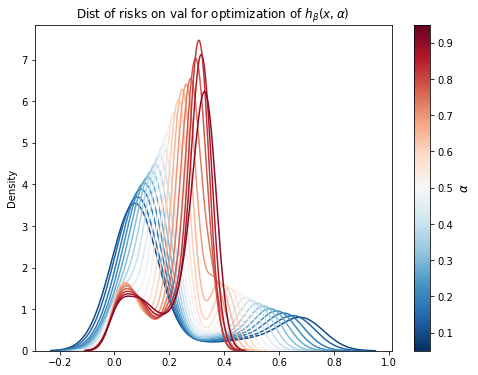

In [13]:
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8,6))
rg = torch.arange(0,1,0.05)
diverging_colors = sns.color_palette("RdBu", len(rg))
j=1
for alpha in tqdm(rg):
    with torch.no_grad():
        risks = torch.stack([loss_fn(data_dict_train[e]['y'].to(device), h(data_dict_train[e]['x'].to(device), alpha.to(device))) for e in data_dict_train.keys()])
        cvar_emp = aggregation_function(name="cvar").aggregate(risks.cpu(), alpha.cpu())     
        sns.kdeplot(risks.cpu().numpy(), ax=ax,color=diverging_colors[len(rg)-j], label=str(alpha.item()))
        print("alpha: ", alpha, " CVaR: ",cvar_emp.item())
    results.at[int(alpha.item()*100), "alpha"] = alpha
    results.at[int(alpha.item()*100), "cvar"] = cvar_emp
    j+=1
ax.legend(bbox_to_anchor=(1.02, 1.02), title=r"$\alpha$", loc='upper left')
ax.set_title(r"Dist of risks on val for optimization of $h_\beta(x,\alpha)$")
norm = plt.Normalize(0.05, 0.95)
sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
sm.set_array([])
ax.get_legend().remove()
ax.figure.colorbar(sm).set_label(label= r'$\alpha$',labelpad=5,size=12)